<h1 style="text-align: center"><b> Diabetes Prediction </b></h1>
<h2 style="text-align: center"> Machine Learning </h2>

In [59]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

In [17]:
data = pd.read_csv("diabetes_prediction_dataset.csv")

In [14]:
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


<h3 style="text-align: center"> Data Preprocessing </h3>

In [19]:
# Assuming your DataFrame is called 'df' and the column is 'gender'
value_counts = data['gender'].value_counts()
#Encode the data
data = pd.read_csv("diabetes_prediction_dataset.csv")

one_hot_encoded = pd.get_dummies(data['gender'])
data = pd.concat([one_hot_encoded, data], axis=1)
data = data.drop("gender", axis=1)

one_hot_encoded = pd.get_dummies(data['smoking_history'])
data = pd.concat([one_hot_encoded, data], axis=1)
data = data.drop("smoking_history",axis=1)

#normalize each feature by dividing by the maximum
data = data / data.max()


In [24]:
data.head()

,No Info,current,ever,former,never,not current,Female,Male,Other,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.000,0.0,1.0,0.263246,0.733333,0.466667,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.675,0.0,0.0,0.285505,0.733333,0.266667,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.350,0.0,0.0,0.285505,0.633333,0.526667,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.450,0.0,0.0,0.245062,0.555556,0.516667,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.950,1.0,1.0,0.210471,0.533333,0.516667,0.0


We now want to check if there are duplicate rows, if so, we will drop them as this will impact our model's prediction. Indeed, if the test data contains data that the model has already been trained on, then the model will have a high accuracy, but we will not know how it would perform with data it has never seen.

In [30]:
isnasum = data.isna().sum()
print("Number of duplicates:", data.duplicated().sum(), "\nNumber of NaN values:",isnasum.sum())

Number of duplicates: 3854 
Number of NaN values: 0


We see that there are quite a few duplicates. We will consider that they are indeed all different persons (which is plausible considering the features), but this means we must deviate from the usual strategy of dividing the dataset into different test and train sets, by making sure all the duplicates are either in the test set, or the train set, bu never in both. This should prevent testing the model on data it has already seen, and prevent the risk of high accuracy score if the model overfits the testing data. 

Now, we will look at the correlation of each features of the data set, as well as the distribution of the data inside the dataset.

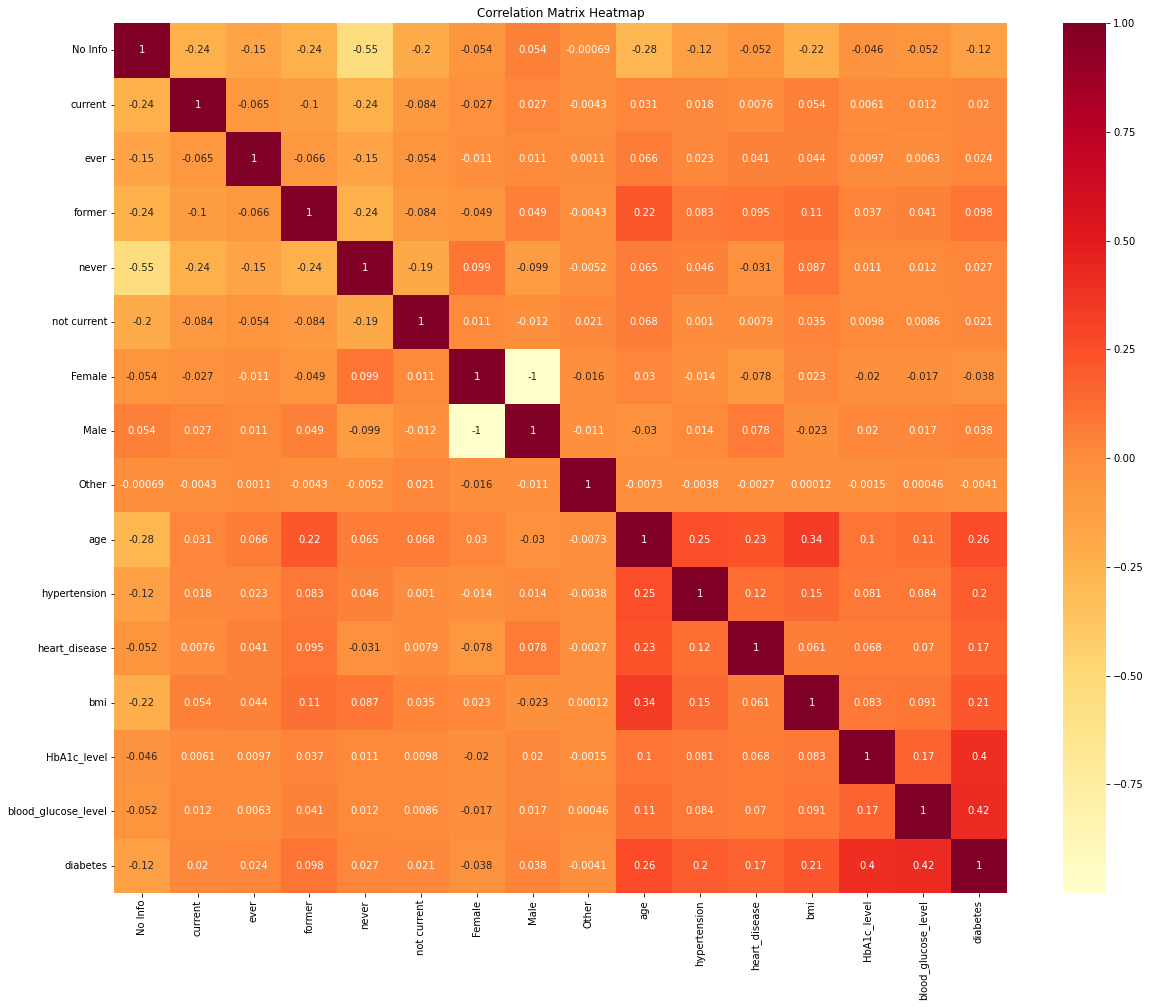

In [57]:
plt.figure(figsize=(20, 16))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlOrRd")
plt.title("Correlation Matrix Heatmap")
plt.show()

We notice that age is very correlated to hypertension, heart_disease and the bmi. We will see in the future if we can improve the model by removing those three features.

We notice that diabetes is very correlated to HbA1c_level and blood_glucose_level.




In [32]:
corr_list_with_diabetes = dict(corr_matrix['diabetes'])
corr_list_with_diabetes_sorted = {k: abs(v) for k, v in sorted(corr_list_with_diabetes.items(), key=lambda item: abs(item[1]))}

print(corr_list_with_diabetes_sorted)



{'Other': 0.004089538097798295, 'current': 0.019605505835478643, 'not current': 0.02073365805714726, 'ever': 0.024080208220788095, 'never': 0.027266862939450735, 'Female': 0.037552572852130026, 'Male': 0.03766632962961672, 'former': 0.09791730613384952, 'No Info': 0.11893878667621564, 'heart_disease': 0.17172684954885264, 'hypertension': 0.197823246408052, 'bmi': 0.21435740579951126, 'age': 0.25800803335609723, 'HbA1c_level': 0.40066031464748914, 'blood_glucose_level': 0.41955799602055627, 'diabetes': 1.0}


Now, let us look at the distribution of the dataset, . This is important to understand how it is distributed, as it will affect which cost function, which model would be more appropriate,...

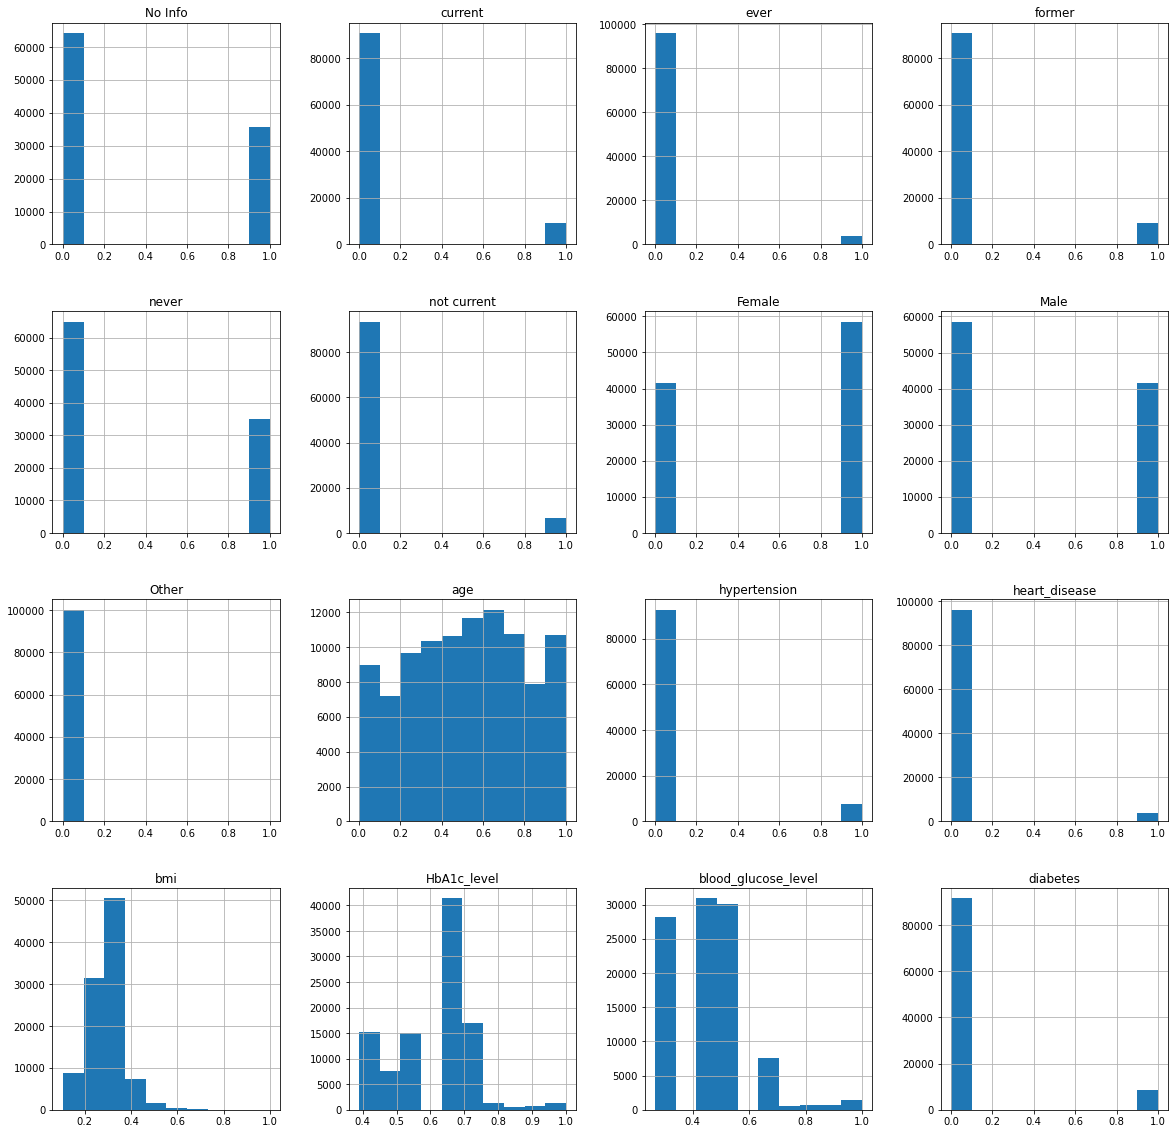

In [33]:
data.describe().T
p = data.hist(figsize = (20,20))

Here, it is extremely interesting to note that, in our dataset, the proportion of people who do not have diabetes is much more important than those who do have diabetes. Age is well distributed, so this is good because we will generalize well on people of all ages, same for gender. 

In [34]:
s = data['diabetes'].to_numpy()
print(f"We have that {sum(s)} patients have diabetes, while {len(s)-sum(s)} don't have it.")

We have that 8500.0 patients have diabetes, while 91500.0 don't have it.


Why is the above relevant? If we made a model which would systematically classify the patient as not having diabetes, we would achieve an accuracy of ~91.5%, which is good, but is clearly not what we are aiming for. The classical loss function is thus not what we might want to use.

In [34]:
s = sum(data['No Info'].to_numpy())
print(f"We have no info on the smoking habits of {s} patients.")

We have no info on the smoking habits of 35816.0 patients.


In [36]:
X = data.iloc[:,:-1]
Y = data.iloc[:,-1:]
X.head()

,No Info,current,ever,former,never,not current,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.000,0.0,1.0,0.263246,0.733333,0.466667
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.675,0.0,0.0,0.285505,0.733333,0.266667
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.350,0.0,0.0,0.285505,0.633333,0.526667
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.450,0.0,0.0,0.245062,0.555556,0.516667
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.950,1.0,1.0,0.210471,0.533333,0.516667


In [44]:
duplicate_rows = data[data.duplicated(keep=False)]
compteur = duplicate_rows.groupby(duplicate_rows.columns.tolist()).size().to_dict()

data_no_dup = data.drop_duplicates(keep=False)


train_set, test_set = train_test_split(data_no_dup, test_size=0.25, random_state=0)
train_set, test_set = list(train_set.to_numpy()), list(test_set.to_numpy())

for (row,number) in compteur.items():
    decision  = random.randint(0, 1)
    if decision==0:
        #we had to the train set
        for _ in range(number):
            index = random.randint(0,len(train_set))
            train_set.insert(index,row)
    
    else:
        for _ in range(number):
            index = random.randint(0,len(test_set))
            test_set.insert(index,row)

train_set, test_set = np.array(train_set), np.array(test_set)

In [45]:
print(train_set.shape, test_set.shape)
print(train_set)

(73208, 16) (26792, 16)
[[0.         0.         0.         ... 0.55555556 0.42       0.        ]
 [1.         0.         0.         ... 0.67777778 0.28333333 0.        ]
 [1.         0.         0.         ... 0.55555556 0.53       0.        ]
 ...
 [1.         0.         0.         ... 0.64444444 0.66666667 0.        ]
 [0.         1.         0.         ... 0.53333333 0.28333333 0.        ]
 [1.         0.         0.         ... 0.44444444 0.26666667 0.        ]]


Let us check that we correctly implemented the test and training sets.

In [46]:
X_train = train_set[:, :-1]  
Y_train = train_set[:, -1]   

print(X_train, X_train.shape)
print(Y_train, Y_train.shape)

[[0.         0.         0.         ... 0.38833734 0.55555556 0.42      ]
 [1.         0.         0.         ... 0.20117045 0.67777778 0.28333333]
 [1.         0.         0.         ... 0.34747623 0.55555556 0.53      ]
 ...
 [1.         0.         0.         ... 0.30609259 0.64444444 0.66666667]
 [0.         1.         0.         ... 0.33253214 0.53333333 0.28333333]
 [1.         0.         0.         ... 0.34308705 0.44444444 0.26666667]] (73208, 15)
[0. 0. 0. ... 0. 0. 0.] (73208,)


In [47]:
X_test = test_set[:, :-1]  
Y_test = test_set[:, -1]  

print(X_test, X_test.shape)
print(Y_test, Y_test.shape)

[[1.         0.         0.         ... 0.28550528 0.73333333 0.51666667]
 [1.         0.         0.         ... 0.21820462 0.66666667 0.53      ]
 [0.         0.         0.         ... 0.28550528 0.73333333 0.53333333]
 ...
 [0.         0.         1.         ... 0.27442784 0.73333333 0.53333333]
 [1.         0.         0.         ... 0.28550528 0.44444444 0.51666667]
 [0.         0.         1.         ... 0.31434842 0.66666667 0.26666667]] (26792, 15)
[0. 0. 0. ... 0. 0. 0.] (26792,)


In [51]:
columns = ['No Info',
 'current',
 'ever',
 'former',
 'never',
 'not current',
 'Female', 'Male', 'Other',
 'age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level']


Y_test = pd.DataFrame(Y_test)
Y_test.columns = ['diabetes']

X_test = pd.DataFrame(X_test)
X_test.columns = columns


X_train = pd.DataFrame(X_train)
X_train.columns = columns

Y_train = pd.DataFrame(Y_train)
Y_train.columns = ['diabetes']







In [58]:
X_train

,No Info,current,ever,former,never,not current,Female,Male,Other,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.4625,0.0,0.0,0.388337,0.555556,0.420000
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0375,0.0,0.0,0.201170,0.677778,0.283333
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.2625,0.0,0.0,0.347476,0.555556,0.530000
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.7125,0.0,0.0,0.427944,0.688889,0.420000
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.6375,0.0,0.0,0.284251,0.500000,0.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73203,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.2500,0.0,0.0,0.217473,0.644444,0.266667
73204,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.7125,0.0,0.0,0.445919,0.555556,0.516667
73205,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6875,0.0,0.0,0.306093,0.644444,0.666667
73206,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.7875,1.0,0.0,0.332532,0.533333,0.283333


## Logistic Regression

We will now build a logistic regression model in order to predict whether an individual has diabetes or not. In our project, we are faced with a binary logistic regression, as our output variable 'diabetes' has only 2 classes. 

In [60]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

/Users/eliehuynh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/eliehuynh/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

We start with an arbitrary value for C, the inverse of the regularization strength, and we will later explore what value of C to use in order to improve our model the most.

In [65]:
y_pred = classifier.predict(X_test)

print(accuracy_score(Y_test, y_pred))
print(balanced_accuracy_score(Y_test, y_pred))

0.9611077933711556
0.8044090670209274


The accuracy is really high, but we can try to understand better the performance of our model. We will first use a confusion matrix which is usually used to understand how well (or bad) each category is classified. In the confusion matrix, each row represents the instances of the actual values, whereas teh columns count the instances of the predicted value. 
The confusion matrix will help us understand when diabetes is correctly or incorrectly predicted or not predicted. 

In [63]:
print(np.where(y_pred==0)[0].shape)
Y_test.loc[Y_test.diabetes ==0]

(25237,)


,diabetes
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
26787,0.0
26788,0.0
26789,0.0
26790,0.0


In [64]:
def confusion(y_test: np.array, y_pred: np.array, labels):
    matrix = confusion_matrix(y_test, y_pred)
    df = pd.DataFrame(matrix,columns=['predicted '+i for i in labels], index=['actual '+i for i in labels])
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
    return df

conf = confusion(Y_test, y_pred, labels=['Negative', 'Positive'])
conf

,predicted Negative,predicted Positive
actual Negative,24398,203
actual Positive,839,1352


We see that only $\frac{820}{21661} = 3.78\%$ of the predicted Negatives were incorrectly predicted, 

F1Score implicit cost matrix

## K nearest neighbours

In [77]:
import sklearn.neighbors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA


Let us try with different number of neighbours and plot the accuracy of the predictions. 

/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/Forcioli/opt/anaconda3/lib/python3.9/site-packages/sk

[0.9429189549009819, 0.9562323181893826, 0.9539440838741887, 0.9573140289565651, 0.9569395906140788, 0.9572308204360126, 0.9568147778332501, 0.9567315693126976, 0.9572308204360126, 0.9564819437510401, 0.9578548843401564, 0.9566067565318689, 0.9580213013812614, 0.9565651522715926]


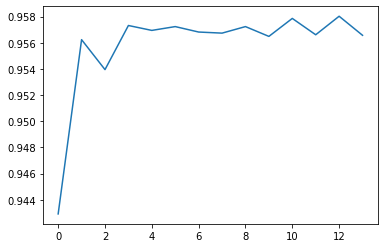

In [18]:
accuracy=[]
for n in range(1,15):
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train,Y_train)
    predictions=model.predict(X_test)
    accuracy+=[accuracy_score(Y_test,predictions)]
    
print(accuracy)
plt.plot(accuracy)
plt.show()

The accuracy is already really good. Let us do a PCA.

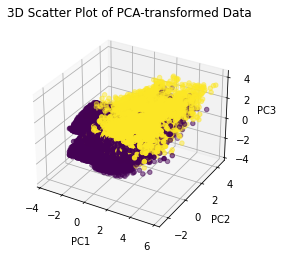

In [25]:
names=['No info','current','ever','former','never','not current','gender','age','hypertension','heart_disease','bmi','HbA1c_level','blood_glucose_level']

pca = decomposition.PCA(n_components=3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
# Plot the 3D scatter plot of the PCA-transformed data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],c=Y)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of PCA-transformed Data')
plt.show()

[0.8758112830753869, 0.9161674155433517, 0.9337244133799301, 0.9536112497919786, 0.9523631219836911, 0.9544433349975038, 0.9539024796139125, 0.9549425861208187, 0.9545265435180562, 0.9603927442170078, 0.9595190547512065, 0.9574388417373939, 0.9584373439840239]


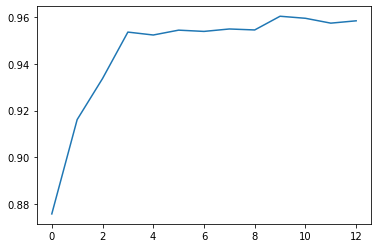

In [27]:
accuracy=[]
for n in range(1,14):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)
    X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size = 0.25,random_state = 42)
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=n)
    Y_train = Y_train.to_numpy().ravel()
    Y_test = Y_test.to_numpy().ravel()
    model.fit(X_train, Y_train)

    predictions=model.predict(X_test)
    accuracy+=[accuracy_score(Y_test,predictions)]
    

print(accuracy)
plt.plot(accuracy)
plt.show()